# Description

This is a simulation of a Client, Cache, DB setup.

## Client
The client sends requests to the Cache for certain objects.
The rate at which the client sends request is ~exp(REQUEST_FREQUENCY).
The kind of object that are requested follow a Zipf distribution.

## Cache
The cache is an intermediate storage for the objects.
It saves the objects, along with their age in the cache and TTL.
When the TTL is over the object expires from the cache.
The age of the object describes the "freshness" of the object from the point when it was pulled from the database.

The cache regularly refreshes the objects in its database, based on ~exp(mu).
The mu is a fixed value, individual to each object.

When the client requests an object and it isn't in the cache, a cache miss occurs and the cache has to get the object from the database.
When the object is in the database at the time the client requests it a cache hit occurs and the TTL of the object is refreshed.

## Database
The database stores the available objects and provides them to the cache when requested.
Along with a value, the database also stores the refresh rate mu for each object.
The refresh rate is used by the cache to periodically refresh the cache information from the database.

In [1]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

# Constants
SEED = 256
CACHE_TTL = 5          # Cache TTL in seconds
CACHE_CAPACITY = 100   # Maximum number of objects the cache can hold
SIMULATION_TIME = 60   # Total time to run the simulation
REQUEST_FREQUENCY = 1   # Mean time between client requests
OBJECT_FREQUENCY_LAMBDA = 1       # Shape parameter for the Zipf distribution (controls skewness)


# Set random seeds
random.seed(SEED)
np.random.seed(SEED)

# Initialize simulation environment
env = simpy.Environment()

In [2]:
class Database:
    def __init__(self):
        # Each object now has a specific refresh rate 'mu'
        self.data = {i: f"Object {i}" for i in range(1, CACHE_CAPACITY + 1)}
        self.mu_values = {i: random.uniform(1, 10) for i in range(1, CACHE_CAPACITY + 1)}  # Assign a random mu for each object


    def get_object(self, obj_id):
        print(f"[{env.now:.2f}] Database: Fetched {self.data.get(obj_id, 'Unknown')} for ID {obj_id}")
        return self.data.get(obj_id, None)

In [3]:
class Cache:
    def __init__(self, env, db):
        self.env = env
        self.db = db
        self.storage = {}  # Dictionary to store cached objects
        self.ttl = {}      # Dictionary to store TTLs
        self.age = {}      # Dictionary to store age of each object
        self.cache_state_over_time = []  # To record cache state at each interval
        self.hits = {i: 0 for i in range(1, CACHE_CAPACITY + 1)}  # Track hits per object
        self.misses = {i: 0 for i in range(1, CACHE_CAPACITY + 1)}  # Track misses per object
        self.cumulative_age = {i: 0 for i in range(1, CACHE_CAPACITY + 1)}  # Track cumulative age per object
        self.access_count = {i: 0 for i in range(1, CACHE_CAPACITY + 1)}  # Track access count per object
        self.next_refresh = {}  # Track the next refresh time for each cached object
        
    def get(self, obj_id):
        if obj_id in self.storage and self.ttl[obj_id] > env.now:
            # Cache hit: increment hit count and update cumulative age
            self.hits[obj_id] += 1
            self.cumulative_age[obj_id] += self.age[obj_id]
            self.access_count[obj_id] += 1
        else:
            # Cache miss: increment miss count
            self.misses[obj_id] += 1
            self.access_count[obj_id] += 1
            
            # Fetch the object from the database if it’s not in cache
            obj = self.db.get_object(obj_id)
            
            # If the cache is full, evict the oldest object
            if len(self.storage) >= CACHE_CAPACITY:
                self.evict_oldest()
            
            # Add the object to cache, set TTL, reset age, and schedule next refresh
            self.storage[obj_id] = obj
            self.ttl[obj_id] = env.now + CACHE_TTL
            self.age[obj_id] = 0
            self.next_refresh[obj_id] = env.now + np.random.exponential(self.db.mu_values[obj_id])  # Schedule refresh

        
    def evict_oldest(self):
        """Remove the oldest item from the cache to make space."""
        oldest_id = max(self.age, key=self.age.get)  # Find the oldest item by age
        print(f"[{env.now:.2f}] Cache: Evicting object {oldest_id} to make space")
        del self.storage[oldest_id]
        del self.ttl[oldest_id]
        del self.age[oldest_id]
        
    def refresh_object(self, obj_id):
        """Refresh the object from the database to keep it up-to-date."""
        obj = self.db.get_object(obj_id)
        self.storage[obj_id] = obj
        self.ttl[obj_id] = env.now + CACHE_TTL
        self.age[obj_id] = 0
        print(f"[{env.now:.2f}] Cache: Refreshed object {obj_id}")
        
    def age_objects(self):
        """Increment age of each cached object."""
        for obj_id in list(self.age.keys()):
            if self.ttl[obj_id] > env.now:
                self.age[obj_id] += 1
                print(f"[{env.now:.2f}] Cache: Object {obj_id} aged to {self.age[obj_id]}")
            else:
                # Remove object if its TTL expired
                print(f"[{env.now:.2f}] Cache: Object {obj_id} expired")
                del self.storage[obj_id]
                del self.ttl[obj_id]
                del self.age[obj_id]
                
    def record_cache_state(self):
        """Record the current cache state (number of objects in cache) over time."""
        self.cache_state_over_time.append((env.now, len(self.storage)))

In [4]:
def age_cache_process(env, cache):
    """Process that ages cache objects over time, removes expired items, and refreshes based on object-specific intervals."""
    while True:
        cache.age_objects()  # Age objects and remove expired ones

        # Refresh objects based on their individual refresh intervals
        for obj_id in list(cache.storage.keys()):
            # Check if it's time to refresh this object based on next_refresh
            if env.now >= cache.next_refresh[obj_id]:
                cache.refresh_object(obj_id)
                # Schedule the next refresh based on the object's mu
                cache.next_refresh[obj_id] = env.now + np.random.exponential(cache.db.mu_values[obj_id])
        
        cache.record_cache_state()  # Record cache state at each time step
        yield env.timeout(1)  # Run every second


In [5]:
def client_request_process(env, cache):
    """Client process that makes requests for objects from the cache."""
    while True:
        # Use numpy's exponential distribution for request interval
        next_request = np.random.exponential(REQUEST_FREQUENCY)
        yield env.timeout(next_request)

        # Use numpy's Zipf distribution to select object ID, reroll if out of bounds
        while True:
            obj_id = np.random.zipf(OBJECT_FREQUENCY_LAMBDA)
            if obj_id <= 100:  # Ensure obj_id is within range [1, 100]
                break  # Valid obj_id, exit loop
            # If obj_id is out of bounds, reroll (continue the loop)
        
        print(f"[{env.now:.2f}] Client: Requesting object {obj_id}")
        cache.get(obj_id)


In [6]:
# Instantiate components
db = Database()
cache = Cache(env, db)

# Start processes
env.process(age_cache_process(env, cache))
env.process(client_request_process(env, cache))

# Run the simulation
env.run(until=SIMULATION_TIME)

[0.05] Client: Requesting object 82
[0.05] Database: Fetched Object 82 for ID 82
[0.07] Client: Requesting object 13
[0.07] Database: Fetched Object 13 for ID 13
[1.00] Cache: Object 82 aged to 1
[1.00] Cache: Object 13 aged to 1
[1.00] Database: Fetched Object 82 for ID 82
[1.00] Cache: Refreshed object 82
[1.00] Database: Fetched Object 13 for ID 13
[1.00] Cache: Refreshed object 13
[1.71] Client: Requesting object 11
[1.71] Database: Fetched Object 11 for ID 11
[1.97] Client: Requesting object 1
[1.97] Database: Fetched Object 1 for ID 1
[2.00] Cache: Object 82 aged to 1
[2.00] Cache: Object 13 aged to 1
[2.00] Cache: Object 11 aged to 1
[2.00] Cache: Object 1 aged to 1
[3.00] Cache: Object 82 aged to 2
[3.00] Cache: Object 13 aged to 2
[3.00] Cache: Object 11 aged to 2
[3.00] Cache: Object 1 aged to 2
[4.00] Cache: Object 82 aged to 3
[4.00] Cache: Object 13 aged to 3
[4.00] Cache: Object 11 aged to 3
[4.00] Cache: Object 1 aged to 3
[4.00] Database: Fetched Object 13 for ID 13
[4.

In [7]:
# Calculate and print hit rate and average age for each object
for obj_id in range(1, CACHE_CAPACITY + 1):
    if cache.hits[obj_id] != 0:
        hit_rate = cache.hits[obj_id] / max(1, cache.access_count[obj_id])  # Avoid division by zero
        avg_age = cache.cumulative_age[obj_id] / max(1, cache.hits[obj_id])  # Only average over hits
        print(f"Object {obj_id}: Hit Rate = {hit_rate:.2f}, Average Age = {avg_age:.2f}")


Object 1: Hit Rate = 0.71, Average Age = 1.50
Object 2: Hit Rate = 0.62, Average Age = 2.20
Object 3: Hit Rate = 0.50, Average Age = 2.33
Object 4: Hit Rate = 0.50, Average Age = 1.00
Object 5: Hit Rate = 0.43, Average Age = 1.00
Object 6: Hit Rate = 0.50, Average Age = 2.33


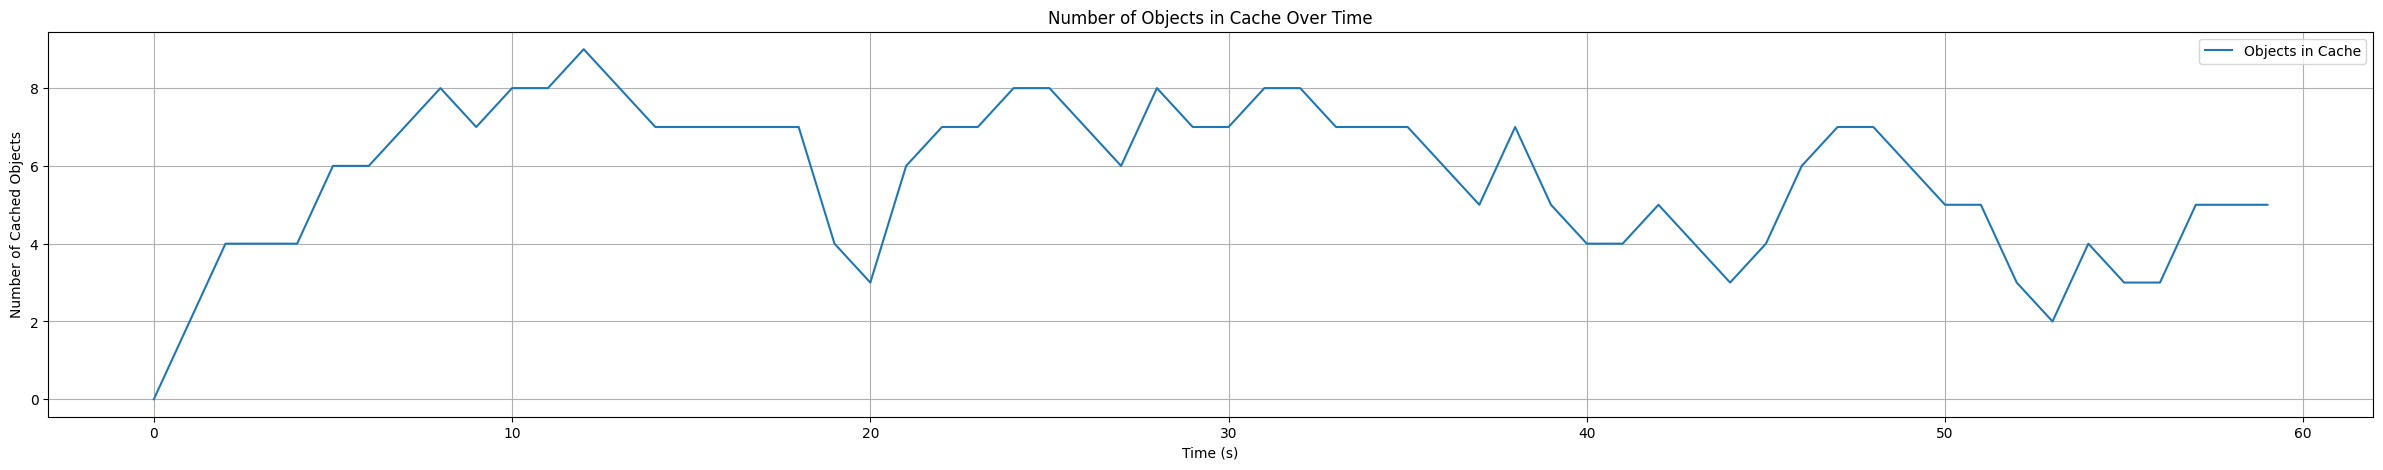

In [8]:
# Extract recorded data for plotting
times, cache_sizes = zip(*cache.cache_state_over_time)

# Plot the cache size over time
plt.figure(figsize=(30, 5))
plt.plot(times, cache_sizes, label="Objects in Cache")
plt.xlabel("Time (s)")
plt.ylabel("Number of Cached Objects")
plt.title("Number of Objects in Cache Over Time")
plt.legend()
plt.grid(True)
plt.show()

Object 1: Hit Rate = 0.99, Average Age = 0.00
Object 2: Hit Rate = 0.97, Average Age = 0.55
Object 3: Hit Rate = 0.96, Average Age = 0.87
Object 4: Hit Rate = 0.94, Average Age = 1.24
Object 5: Hit Rate = 0.18, Average Age = 2.33
Object 6: Hit Rate = 0.09, Average Age = 4.00
Object 9: Hit Rate = 0.25, Average Age = 2.33
Object 10: Hit Rate = 0.08, Average Age = 0.00
Object 11: Hit Rate = 0.25, Average Age = 1.00
Object 12: Hit Rate = 0.29, Average Age = 1.00

Object 1: Hit Rate = 0.99, Average Age = 0.00
Object 2: Hit Rate = 0.97, Average Age = 0.56
Object 3: Hit Rate = 0.96, Average Age = 0.78
Object 4: Hit Rate = 0.92, Average Age = 1.83
Object 5: Hit Rate = 0.14, Average Age = 0.00
Object 7: Hit Rate = 0.29, Average Age = 2.00
Object 24: Hit Rate = 0.50, Average Age = 1.00
Object 44: Hit Rate = 0.33, Average Age = 1.00

Object 1: Hit Rate = 0.99, Average Age = 0.00
Object 2: Hit Rate = 0.97, Average Age = 0.42
Object 3: Hit Rate = 0.95, Average Age = 1.38
Object 4: Hit Rate = 0.96, Average Age = 1.44
Object 7: Hit Rate = 0.33, Average Age = 3.20
Object 23: Hit Rate = 0.50, Average Age = 1.00

Object 1: Hit Rate = 0.99, Average Age = 0.00
Object 2: Hit Rate = 0.97, Average Age = 0.65
Object 3: Hit Rate = 0.96, Average Age = 0.81
Object 4: Hit Rate = 0.91, Average Age = 1.90
Object 5: Hit Rate = 0.08, Average Age = 3.00
Object 6: Hit Rate = 0.12, Average Age = 3.50
Object 7: Hit Rate = 0.12, Average Age = 3.00
Object 15: Hit Rate = 0.33, Average Age = 4.00
Object 65: Hit Rate = 0.50, Average Age = 0.00